In [150]:
import hmmlearn as hmm
import numpy as np
import glob
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hmmlearn import hmm
import seaborn as sns
from scipy.stats import zscore

In [337]:
#https://stats.stackexchange.com/questions/384556/how-to-infer-the-number-of-states-in-a-hidden-markov-model-with-gaussian-mixture

def bic_aic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    bic = np.log(len(X))*k - 2*likelihood_fn
    aic = -2*likelihood_fn + 2*k + 2*k*(k+1)/(len(X)-k-1)
    return bic, aic

def bic_aic_hmmlearn(X, lenghts):
    lowest_aic = np.infty
    lowest_bic = np.infty
    bic = []
    aic = []
    
    n_states_range = range(2,30)
    for n_components in n_states_range:
        hmm_curr = hmm.GaussianHMM(n_components=n_components, covariance_type='full',n_iter=100, random_state=42)
        hmm_curr.fit(X, lenghts)

        # Calculate number of free parameters
        # free_parameters = for_means + for_covars + for_transmat + for_startprob
        # for_means & for_covars = n_features*n_components
        n_features = hmm_curr.n_features
        free_parameters = n_components*n_features + (n_components*n_features*n_features)+ n_components*(n_components-1) + (n_components-1) 
        score = hmm_curr.score(X, lenghts)

        bic_curr, aic_curr = bic_aic_general(score, free_parameters, X)
        bic.append(bic_curr)
        aic.append(aic_curr)
            
        if bic_curr < lowest_bic:
            lowest_bic = bic_curr
            best_hmm_bic = hmm_curr
        
        if aic_curr < lowest_aic:
            lowest_aic = aic_curr
            best_hmm_aic = hmm_curr

    return (best_hmm_bic, best_hmm_aic, bic, aic, list(n_states_range))


In [338]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"

In [339]:
scaler = StandardScaler()
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [340]:
def get_time_series_all(dirpath, subects, stimulus, scan, parcel):
    
    subject_list = []
    series_array = []
    
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        #scaled_series = series.apply(zscore)
        scaled_series = series.T
        scaled_series['network'] = schafer['network']
        scaled_series.drop(scaled_series.index[scaled_series['network'] == 'Limbic'], inplace=True)
        del scaled_series['network']
        series_array.append(scaled_series.values.T)
    return series_array

In [341]:
def get_all_data(scans, stimuli,subjects, dirpath, parcel): 
    
    scans_arrray = []
    
    for scan in scans:
        all_stimulus_array = []
        
        for stimulus in stimuli:
            stimulus_array = get_time_series_all(dirpath, subjects, stimulus, scan, parcel)
            all_stimulus_array.extend(stimulus_array)
    scans_arrray.extend(all_stimulus_array)
            
    return scans_arrray

In [342]:
def average_zscore(array):
    all_subjects = []
    for subject_array in array:
        df_array = pd.DataFrame(subject_array.T)
        df_array['network'] = networks
        series_average = df_array.groupby('network').mean()
        #scaler = StandardScaler()
        #scaled_series = scaler.fit_transform(series_average.T)
        #print(scaled_series)
        scaled_series = series_average.T.apply(zscore)
       
        all_subjects.append(scaled_series.values)
    return(np.array(all_subjects))

In [343]:
scans = ['_scan_restpre']
stimuli = ['ses-occ', 'ses-fro' ]

pre_occ = np.array(get_all_data(['_scan_restpre'], ['ses-occ'],subjects, dirpath, parcel))

pre_fro = np.array(get_all_data(['_scan_restpre'], ['ses-fro'],subjects, dirpath, parcel))
average_pre = (pre_occ  + pre_fro) / 2

all_networks = schafer['network']
all_networks.drop(all_networks.index[all_networks == 'Limbic'], inplace=True)
networks = all_networks.values

In [344]:
pre_sequences = average_zscore(average_pre)
pre_concatenated = pre_sequences.reshape(-1, pre_sequences.shape[-1])
lenghts = np.array([600 for i in range(23)])

In [345]:
pre_concatenated.max()

5.346907181595933

In [346]:
best_hmm_bic, best_hmm_aic, bic, aic, states = bic_aic_hmmlearn(pre_concatenated, lenghts.T)

In [347]:
best_hmm_bic

GaussianHMM(covariance_type='full', n_components=9, n_iter=100, random_state=42)

In [348]:
best_hmm_aic

GaussianHMM(covariance_type='full', n_components=21, n_iter=100,
            random_state=42)

<AxesSubplot:>

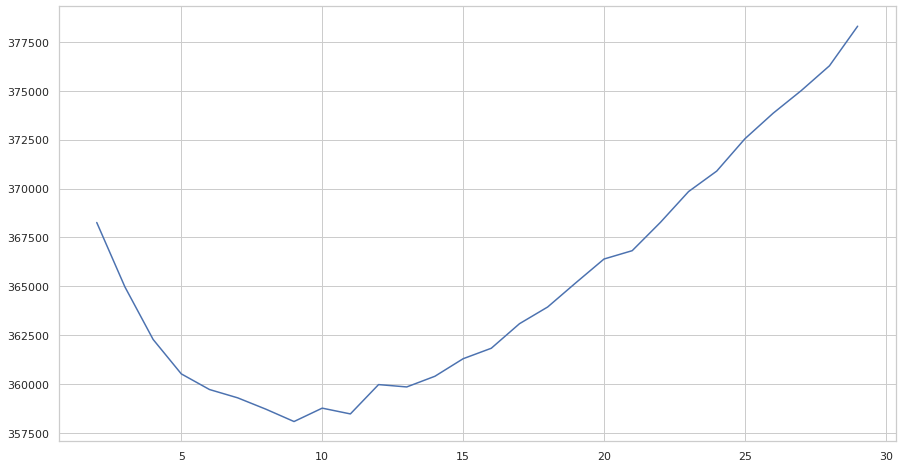

In [349]:
sns.lineplot(x=states, y=bic)


<AxesSubplot:>

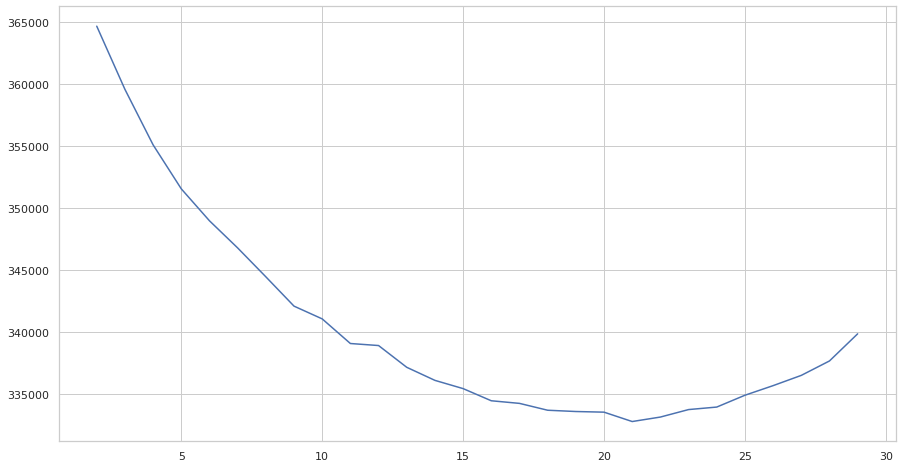

In [350]:
sns.lineplot(x=states, y=aic)

<AxesSubplot:>

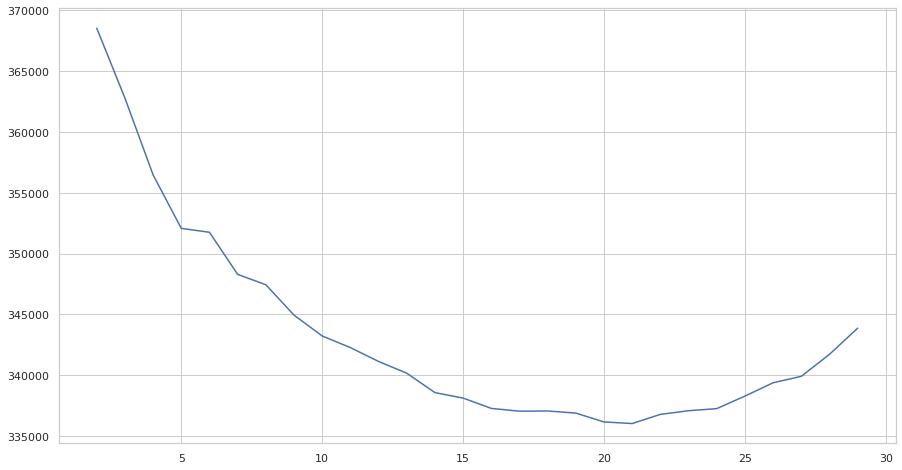

In [351]:
sns.lineplot(x=states, y=aicc)

<AxesSubplot:xlabel='Estado', ylabel='Valor'>

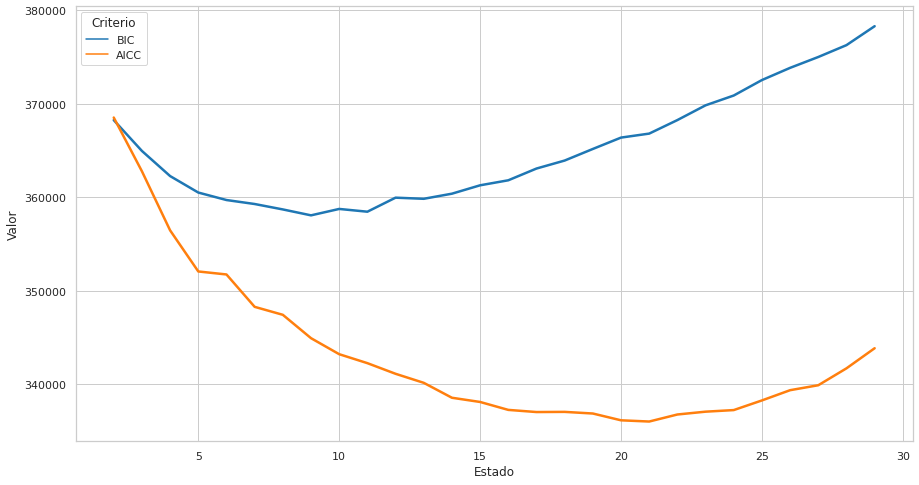

In [352]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")

data = pd.DataFrame(np.array([states,bic,aicc]).T, columns=["Estado","BIC","AICC"])
data_m = data.melt(id_vars=['Estado'],var_name='Criterio', value_name='Valor')
sns.lineplot(x="Estado", y="Valor", hue="Criterio", data=data_m,palette="tab10", linewidth=2.5)